## Time Series Anomaly Detection Exercise 
- Updated by commenting code and adding takeaways

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# for readability, remove pink warning boxes
import warnings
warnings.filterwarnings('ignore')

# import necessary functions
import tsad_functions

In [2]:
import pandas as pd

def acquire(file_name, column_names):
    '''
    This function takes in a .csv file and column_names and returns the .csv written 
    to a dataframe. The function uses only 5 columns (0, 2, 3, 4, 5) of the original 
    .csv file and removes the header row of the .csv file and replaces it with given 
    column_names
    '''
    return pd.read_csv(file_name, sep = '\s', header=None, names = column_names, usecols=[0, 2, 3, 4, 5])

def prep(df, user): 
    '''
    This functions takes in a dataframe and user_id number, preps the 
    data by creating a dataframe for an individual user, setting the date
    as a datetime index. It returns a count of the user's endpoints by day"
    '''
    # create a dataframe containing only the given user_id
    df = df[df.user_id == user]
    
    # convert date to datetime datatype
    df.date = pd.to_datetime(df.date)
    
    # reset dataframe index to date
    df = df.set_index(df.date)
    
    # create a series of the count of user endpoints by day
    pages = df['endpoint'].resample('d').count()
    
    return pages


def compute_pct_b(pages, span, weight, user):
    '''
    This function takes in a series, date span, bollinger weight and user_id
    and returns a dataframe containing the user_id, pages, the upper, lower and 
    mid Bollinger Bands and %b (percent bandwidth)
    '''
    
    # calculate the midband, or exponential moving average
    midband = pages.ewm(span=span).mean()
    
    # calculate standard deviation of pages data
    stdev = pages.ewm(span=span).std()
    
    # calculate the upper and lower bands based on std and given weight
    ub = midband + (stdev * weight)
    lb = midband - (stdev * weight)
    
    # create a dataframe of pages and bollinger bands
    bb = pd.concat([ub, lb], axis=1)
    my_df = pd.concat([pages, midband, bb], axis=1)
    my_df.columns = ['pages','midband','ub','lb']
    
    # calculate percent bandwidth (%b) and add to dataframe
    my_df['pct_b'] = (my_df['pages'] - my_df['lb']) / (my_df['ub'] - my_df['lb'])
    
    # create column for user id
    my_df['user_id'] = user
    
    return my_df


def plt_bands(my_df, user):
    '''
    This function takes in a dataframe and user id and returns a plot of number of
    pages accessed by the user over time, including Bollinger bands
    '''
    
    # set figure size
    fig, ax = plt.subplots(figsize=(12,8))
    
    # plot columns and labels
    ax.plot(my_df.index, my_df.pages, label='Number of Pages, User: '+str(user))
    ax.plot(my_df.index, my_df.midband, label='EMA/midband')
    ax.plot(my_df.index, my_df.ub, label='Upper Band')
    ax.plot(my_df.index, my_df.lb, label='Lower Band')
    
    # set legend and ylabel
    ax.legend(loc='best')
    ax.set_ylabel('Number of Pages')
    
    plt.show()
    
    
    
def find_anomalies(df,user, span, weight):
    '''
    This function takes in a dataframe, user id, date span and Bollinger weight and 
    returns a dataframe of anomalies (with values where pct_b>1).  This function 
    relies on helper functions: prep(), compute_pct_b().
    '''
    
    # return a series with a count of the user's endpoints by day
    pages = prep(df, user)
    
    # create a dataframe  of user_id, pages, the upper, lower and mid Bollinger Bands and %b (percent bandwidth)
    my_df = compute_pct_b(pages, span, weight, user)
    
    # return dataframe of anomalies for user
    return my_df[my_df.pct_b>1]

    
def find_anomalies_with_plots(df,user, span, weight):
    '''
    This function takes in a dataframe, user id, date span and Bollinger weight and 
    returns a dataframe of anomalies (with values where pct_b>1).  This function 
    relies on helper functions: prep(), compute_pct_b().
    '''
    
    # return a series with a count of the user's endpoints by day
    pages = prep(df, user)
    
    # create a dataframe  of user_id, pages, the upper, lower and mid Bollinger Bands and %b (percent bandwidth)
    my_df = compute_pct_b(pages, span, weight, user)
    
    # create a plot of page access and 
    plt_bands(my_df, user)
    
    # return dataframe of anomalies for user
    return my_df[my_df.pct_b>1]

In [3]:
#acquire the data, define file name and column names
file_name = 'anonymized-curriculum-access.txt.gz'
column_names = ['date','endpoint','user_id','cohort_id','source_ip']
df = tsad_functions.acquire(file_name, column_names)
df.head()

,date,endpoint,user_id,cohort_id,source_ip
0,2018-01-26,/,1,8.0,97.105.19.61
1,2018-01-26,java-ii,1,8.0,97.105.19.61
2,2018-01-26,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,javascript-i/conditionals,2,22.0,97.105.19.61


In [4]:
# change date to datetime data type and reset it to index
df.date = pd.to_datetime(df.date)
df = df.set_index(df.date)

# create a series of page counts per user per day
pages = df['endpoint'].resample('d').count()
pages.head()

date
2018-01-26    572
2018-01-27    230
2018-01-28    170
2018-01-29    830
2018-01-30    652
Freq: D, Name: endpoint, dtype: int64

In [5]:
pages.isnull().sum()

0

In [6]:
# calculate 7, 14, 30 and 90-day EMAs (exponential moving average)
ema_7d = pages.ewm(span=7).mean()
ema_14d = pages.ewm(span=14).mean()
ema_30d = pages.ewm(span=30).mean()
ema_90d = pages.ewm(span=90).mean()

ema_90d.head()

date
2018-01-26    572.000000
2018-01-27    399.100000
2018-01-28    321.030081
2018-01-29    452.545042
2018-01-30    494.228442
Freq: D, Name: endpoint, dtype: float64

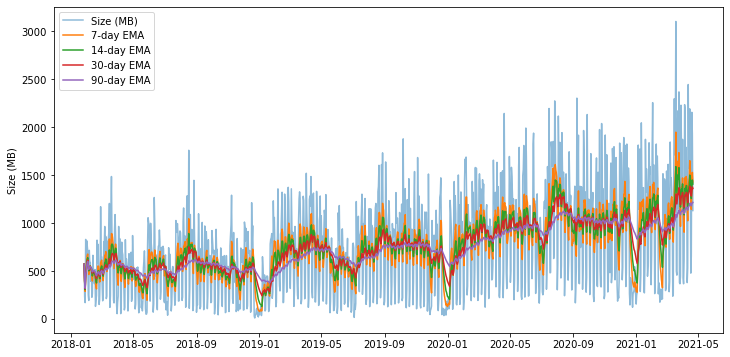

In [7]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(pages.index, pages, label='Size (MB)', alpha = .5)

ax.plot(pages.index, ema_7d, label='7-day EMA')
ax.plot(pages.index, ema_14d, label='14-day EMA')
ax.plot(pages.index, ema_30d, label='30-day EMA')
ax.plot(pages.index, ema_90d, label='90-day EMA')

ax.legend(loc='best')
ax.set_ylabel('Size (MB)')

plt.show()

In [8]:
# set the span (in days)
span = 30

#compute the midband (mean)
midband = pages.ewm(span=span).mean()

midband.head()

date
2018-01-26    572.000000
2018-01-27    395.300000
2018-01-28    315.139578
2018-01-29    457.002386
2018-01-30    501.369064
Freq: D, Name: endpoint, dtype: float64

In [9]:
# compute exponential standard deviation
stdev = pages.ewm(span=span).std()

stdev.head()

date
2018-01-26           NaN
2018-01-27    241.830519
2018-01-28    213.878138
2018-01-29    316.467837
2018-01-30    284.479727
Freq: D, Name: endpoint, dtype: float64

In [10]:
# computer upper and lower bands (by add/sub std*weight from ub and lb)
ub = midband + stdev * 3
lb = midband - stdev * 3

In [11]:
# concatenate ub and lb together into one dataframe and name columns
bb = pd.concat([ub, lb], axis =1)
bb.columns = ['ub', 'lb']
bb.head()

,ub,lb
date,,
2018-01-26,NaN,NaN
2018-01-27,1120.791557,-330.191557
2018-01-28,956.773991,-326.494835
2018-01-29,1406.405897,-492.401124
2018-01-30,1354.808245,-352.070116


In [12]:
# concatenate to add pages and midband columns to bb
pages = pd.concat([pages, midband, bb], axis =1)
pages.columns = ['pages','midband','ub','lb']
pages.head()

,pages,midband,ub,lb
date,,,,
2018-01-26,572,572.000000,NaN,NaN
2018-01-27,230,395.300000,1120.791557,-330.191557
2018-01-28,170,315.139578,956.773991,-326.494835
2018-01-29,830,457.002386,1406.405897,-492.401124
2018-01-30,652,501.369064,1354.808245,-352.070116


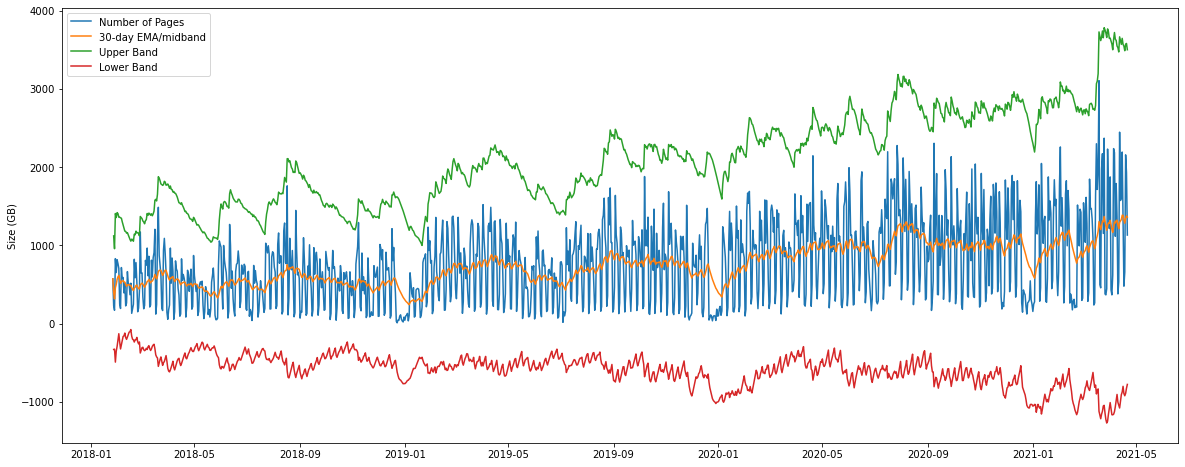

In [13]:
#Plot the bands on pages data
fig, ax = plt.subplots(figsize=(20,8))

ax.plot(pages.index, pages.pages, label='Number of Pages')


ax.plot(pages.index, pages.midband, label='30-day EMA/midband')
ax.plot(pages.index, pages.ub, label='Upper Band')
ax.plot(pages.index, pages.lb, label='Lower Band')

ax.legend(loc='best')
ax.set_ylabel('Size (GB)')

plt.show()

In [14]:
# get the last measure (actual/blue) of GB
last_measure = pages.iloc[-1].pages
last_measure

1131.0

In [15]:
# get the lower band value on the last date
last_lb = pages.iloc[-1].lb
last_lb

-777.340451135389

In [16]:
#get the upper band value on the last date
last_ub = pages.iloc[-1].ub
last_ub

3499.0943598250406

In [17]:
# compute the percent of bandwidth (%b) on the last day
last_pct_b = (last_measure - last_lb) / (last_ub - last_lb)
print('%b for thre last datapoint: ', round(last_pct_b, 2))

%b for thre last datapoint:  0.45


In [18]:
pages.tail()


,pages,midband,ub,lb
date,,,,
2021-04-17,478,1325.179115,3545.216722,-894.858492
2021-04-18,659,1282.199817,3486.733695,-922.334061
2021-04-19,2156,1338.574023,3569.147958,-891.999913
2021-04-20,1930,1376.730537,3579.231798,-825.770723
2021-04-21,1131,1360.876954,3499.094360,-777.340451


In [19]:
# Create a %b for each point in time
pages['pct_b'] = (pages['pages'] - pages['lb']) / (pages['ub'] - pages['lb'])
pages.head()

,pages,midband,ub,lb,pct_b
date,,,,,
2018-01-26,572,572.000000,NaN,NaN,NaN
2018-01-27,230,395.300000,1120.791557,-330.191557,0.386077
2018-01-28,170,315.139578,956.773991,-326.494835,0.386899
2018-01-29,830,457.002386,1406.405897,-492.401124,0.696438
2018-01-30,652,501.369064,1354.808245,-352.070116,0.588249


In [20]:
# Checking for anomalies where %b is greater than 1
pages[pages['pct_b']>1]

,pages,midband,ub,lb,pct_b
date,,,,,


In [21]:
# Test on a single user

In [22]:
user = 1
span = 30
weight = 6
user_df = tsad_functions.find_anomalies(df, user, span, weight)

anomalies = pd.DataFrame()
user_df = tsad_functions.find_anomalies(df, user, span, weight)
anomalies = pd.concat([anomalies, user_df], axis =0)

In [23]:
# Loop through list to apply to EVERY user

span = 30
weight = 2

anomalies = pd.DataFrame()
for u in list(df.user_id.unique()):
    user_df = tsad_functions.find_anomalies(df,u,span,weight)
    anomalies = pd.concat([anomalies, user_df], axis =0)

In [24]:
anomalies

,pages,midband,ub,lb,pct_b,user_id
date,,,,,,
2018-02-20,54,6.456745,35.718248,-22.804758,1.312386,1
2018-03-19,35,9.304089,32.368632,-13.760453,1.057044,1
2018-05-04,27,7.179313,24.736171,-10.377545,1.064471,1
2018-05-11,27,8.141119,26.687629,-10.405390,1.008421,1
2018-05-29,68,9.612443,44.787234,-25.562347,1.329963,1
...,...,...,...,...,...,...
2021-03-29,28,6.004114,24.426496,-12.418268,1.096988,948
2021-04-17,25,8.260254,23.336345,-6.815837,1.055175,948
2021-04-18,50,11.264267,37.649246,-15.120712,1.234049,948


In [25]:
anomalies.user_id.value_counts()

64     51
53     49
1      46
11     45
315    44
       ..
42      1
947     1
30      1
949     1
951     1
Name: user_id, Length: 825, dtype: int64

In [26]:
anomalies.loc[anomalies.user_id == 840]

,pages,midband,ub,lb,pct_b,user_id
date,,,,,,
2021-01-28,19,4.797847,18.980766,-9.385073,1.000678,840
2021-02-02,26,6.291355,23.037638,-10.454929,1.088448,840
2021-02-04,34,8.527620,29.617218,-12.561978,1.103909,840
2021-03-08,24,6.045935,19.985133,-7.893263,1.144014,840
2021-03-15,30,8.290850,25.434092,-8.852391,1.133169,840
2021-03-25,28,7.993541,25.403238,-9.416156,1.074578,840
2021-04-01,29,8.397668,27.299582,-10.504246,1.044980,840
2021-04-04,33,9.709230,30.926912,-11.508452,1.048853,840


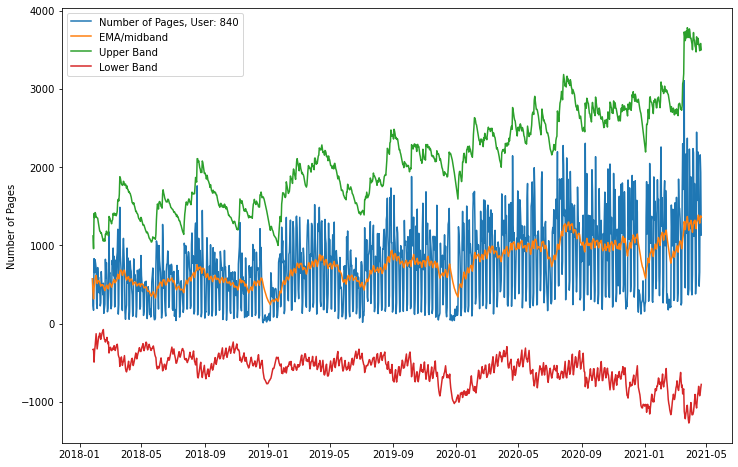

In [28]:
# plot bands for a single user -- (me)
plt_bands(pages, 840)